In [1]:
import qiskit
import numpy as np
from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit, Aer, execute, IBMQ
from qiskit.quantum_info import partial_trace, state_fidelity, Statevector, Pauli, PauliList
from qiskit.opflow import I, X, Y, Z, PauliOp

import matplotlib.pyplot as plt

In [2]:
qiskit.__qiskit_version__

{'qiskit-terra': '0.21.1', 'qiskit-aer': '0.10.4', 'qiskit-ignis': None, 'qiskit-ibmq-provider': '0.19.2', 'qiskit': '0.37.1', 'qiskit-nature': None, 'qiskit-finance': None, 'qiskit-optimization': None, 'qiskit-machine-learning': None}

### Program to perform error analysis of [5,1,3] code. This program will calculate the theoretically expected asymptotic scaling of logical error rate with physical error rate, by computing which error patterns along with the naive correction leads to a non-trivial operation on the codespace, i.e. a logical error.

#### Generate all full code capacity errors (Pauli X/Y/Z on the 5 data qubits with probability p/3, no error with probability (1-p), i.i.d.)

In [3]:
errors_1_qubit = ['I','X','Y','Z']

errors_5_qubit = []

for e1 in errors_1_qubit:
    for e2 in errors_1_qubit:
        for e3 in errors_1_qubit:
            for e4 in errors_1_qubit:
                for e5 in errors_1_qubit:
                    errors_5_qubit.append(e1+e2+e3+e4+e5)

print(errors_5_qubit[0:10])

['IIIII', 'IIIIX', 'IIIIY', 'IIIIZ', 'IIIXI', 'IIIXX', 'IIIXY', 'IIIXZ', 'IIIYI', 'IIIYX']


#### Write all stabilizer generators

In [4]:
stab_gens = ['XZZXI', 'IXZZX', 'XIXZZ', 'ZXIXZ']

#### Check which error strings anti commute with which stabilizer generators and apply "corrections" based on syndrome naively. This would lead to the overall operation experienced by data qubits under every error and the "corrections".

In [5]:
error_strings_commutation = []

for e in errors_5_qubit:
    ec = ''
    for i in range(len(stab_gens)):
        if(Pauli(e).commutes(Pauli(stab_gens[i]))):
            ec += '0'
        elif(Pauli(e).anticommutes(Pauli(stab_gens[i]))):
            ec += '1'
    error_strings_commutation.append(ec)
print(error_strings_commutation)

['0000', '0011', '0111', '0100', '0110', '0101', '0001', '0010', '1111', '1100', '1000', '1011', '1001', '1010', '1110', '1101', '1100', '1111', '1011', '1000', '1010', '1001', '1101', '1110', '0011', '0000', '0100', '0111', '0101', '0110', '0010', '0001', '1110', '1101', '1001', '1010', '1000', '1011', '1111', '1100', '0001', '0010', '0110', '0101', '0111', '0100', '0000', '0011', '0010', '0001', '0101', '0110', '0100', '0111', '0011', '0000', '1101', '1110', '1010', '1001', '1011', '1000', '1100', '1111', '1000', '1011', '1111', '1100', '1110', '1101', '1001', '1010', '0111', '0100', '0000', '0011', '0001', '0010', '0110', '0101', '0100', '0111', '0011', '0000', '0010', '0001', '0101', '0110', '1011', '1000', '1100', '1111', '1101', '1110', '1010', '1001', '0110', '0101', '0001', '0010', '0000', '0011', '0111', '0100', '1001', '1010', '1110', '1101', '1111', '1100', '1000', '1011', '1010', '1001', '1101', '1110', '1100', '1111', '1011', '1000', '0101', '0110', '0010', '0001', '0011',

In [6]:
syndrome_lookup_table={'0000': 'IIIII',
                       '0001': 'XIIII',
                       '1000': 'IXIII',
                       '1100': 'IIXII',
                       '0110': 'IIIXI',
                       '0011': 'IIIIX',
                       '1010': 'ZIIII',
                       '0101': 'IZIII',
                       '0010': 'IIZII',
                       '1001': 'IIIZI',
                       '0100': 'IIIIZ',
                       '1011': 'YIIII',
                       '1101': 'IYIII',
                       '1110': 'IIYII',
                       '1111': 'IIIYI',
                       '0111': 'IIIIY'}

errors_5_qubit_corrected = []

for i in range(len(errors_5_qubit)):
    errors_5_qubit_corrected.append(Pauli(syndrome_lookup_table[error_strings_commutation[i]])@Pauli(errors_5_qubit[i]))
    
print(errors_5_qubit_corrected)

[Pauli('IIIII'), Pauli('IIIII'), Pauli('IIIII'), Pauli('IIIII'), Pauli('IIIII'), Pauli('IZIXX'), Pauli('XIIXY'), Pauli('IIZXZ'), Pauli('IIIII'), Pauli('IIXYX'), Pauli('IXIYY'), Pauli('YIIYZ'), Pauli('IIIII'), Pauli('ZIIZX'), Pauli('IIYZY'), Pauli('IYIZZ'), Pauli('IIIII'), Pauli('IIXYX'), Pauli('YIXIY'), Pauli('IXXIZ'), Pauli('ZIXXI'), Pauli('iIIXYX'), Pauli('IYXXY'), Pauli('-iIIZXZ'), Pauli('IIXYX'), Pauli('IIXYX'), Pauli('-iIIXYX'), Pauli('iIIXYX'), Pauli('IZXZI'), Pauli('-iIIXYX'), Pauli('iIIYZY'), Pauli('XIXZZ'), Pauli('IIIII'), Pauli('IYYIX'), Pauli('IIYZY'), Pauli('ZIYIZ'), Pauli('IXYXI'), Pauli('YIYXX'), Pauli('-iIIYZY'), Pauli('iIIZXZ'), Pauli('XIYYI'), Pauli('-iIIXYX'), Pauli('iIIYZY'), Pauli('IZYYZ'), Pauli('IIYZY'), Pauli('iIIYZY'), Pauli('IIYZY'), Pauli('-iIIYZY'), Pauli('IIIII'), Pauli('XIZIX'), Pauli('IZZIY'), Pauli('IIZXZ'), Pauli('IIZXZ'), Pauli('-iIIZXZ'), Pauli('iIIZXZ'), Pauli('IIZXZ'), Pauli('IYZYI'), Pauli('iIIXYX'), Pauli('ZIZYY'), Pauli('-iIIZXZ'), Pauli('YIZZI'),

#### Determine which errors give an overall non-identity OR non-stabilizer operation even after "correction", upto overall phase.
#### These should be the logical error scenarios.
#### Generate all stabilizers

In [7]:
stab_overcomplete = []

for si in stab_gens:
    stab_overcomplete.append(Pauli(si))

for si in stab_gens:
    for sj in stab_gens:
        stab_overcomplete.append(Pauli(si)@Pauli(sj))
        
for si in stab_gens:
    for sj in stab_gens:
        for sk in stab_gens:
            stab_overcomplete.append(Pauli(si)@(Pauli(sj)@Pauli(sk)))
            
for si in stab_gens:
    for sj in stab_gens:
        for sk in stab_gens:
            for sl in stab_gens:
                stab_overcomplete.append(Pauli(si)@(Pauli(sj)@(Pauli(sk)@Pauli(sl))))

print(len(stab_overcomplete))
print(stab_overcomplete)

340
[Pauli('XZZXI'), Pauli('IXZZX'), Pauli('XIXZZ'), Pauli('ZXIXZ'), Pauli('IIIII'), Pauli('XYIYX'), Pauli('IZYYZ'), Pauli('YYZIZ'), Pauli('XYIYX'), Pauli('IIIII'), Pauli('XXYIY'), Pauli('ZIZYY'), Pauli('IZYYZ'), Pauli('XXYIY'), Pauli('IIIII'), Pauli('YXXYI'), Pauli('YYZIZ'), Pauli('ZIZYY'), Pauli('YXXYI'), Pauli('IIIII'), Pauli('XZZXI'), Pauli('IXZZX'), Pauli('XIXZZ'), Pauli('ZXIXZ'), Pauli('IXZZX'), Pauli('XZZXI'), Pauli('IYXXY'), Pauli('YZIZY'), Pauli('XIXZZ'), Pauli('IYXXY'), Pauli('XZZXI'), Pauli('ZYYZI'), Pauli('ZXIXZ'), Pauli('YZIZY'), Pauli('ZYYZI'), Pauli('XZZXI'), Pauli('IXZZX'), Pauli('XZZXI'), Pauli('IYXXY'), Pauli('YZIZY'), Pauli('XZZXI'), Pauli('IXZZX'), Pauli('XIXZZ'), Pauli('ZXIXZ'), Pauli('IYXXY'), Pauli('XIXZZ'), Pauli('IXZZX'), Pauli('YIYXX'), Pauli('YZIZY'), Pauli('ZXIXZ'), Pauli('YIYXX'), Pauli('IXZZX'), Pauli('XIXZZ'), Pauli('IYXXY'), Pauli('XZZXI'), Pauli('ZYYZI'), Pauli('IYXXY'), Pauli('XIXZZ'), Pauli('IXZZX'), Pauli('YIYXX'), Pauli('XZZXI'), Pauli('IXZZX'), Pau

#### Extract unique entries

In [8]:
stab_full = []
for si in stab_overcomplete:
    if si not in stab_full:
        stab_full.append(si)

print(len(stab_full))
print(stab_full)

16
[Pauli('XZZXI'), Pauli('IXZZX'), Pauli('XIXZZ'), Pauli('ZXIXZ'), Pauli('IIIII'), Pauli('XYIYX'), Pauli('IZYYZ'), Pauli('YYZIZ'), Pauli('XXYIY'), Pauli('ZIZYY'), Pauli('YXXYI'), Pauli('IYXXY'), Pauli('YZIZY'), Pauli('ZYYZI'), Pauli('YIYXX'), Pauli('ZZXIX')]


#### Collect those error combinations whose correction will lead to a logical error on an arbitrary encoded state.

In [9]:
logical_error_indicator = []

for j in range(len(errors_5_qubit_corrected)):
    if(any([errors_5_qubit_corrected[j].equiv(i) for i in stab_full])):
        logical_error_indicator.append(False)
    else:
        logical_error_indicator.append(True)

print(len(logical_error_indicator))

logical_errors = []
for j in range(len(errors_5_qubit)):
    if(logical_error_indicator[j]):
        logical_errors.append(errors_5_qubit[j])

print(len(logical_errors))
print(logical_errors)

1024
768
['IIIXX', 'IIIXY', 'IIIXZ', 'IIIYX', 'IIIYY', 'IIIYZ', 'IIIZX', 'IIIZY', 'IIIZZ', 'IIXIX', 'IIXIY', 'IIXIZ', 'IIXXI', 'IIXXX', 'IIXXZ', 'IIXYI', 'IIXYX', 'IIXYY', 'IIXYZ', 'IIXZI', 'IIXZX', 'IIXZY', 'IIYIX', 'IIYIY', 'IIYIZ', 'IIYXI', 'IIYXY', 'IIYXZ', 'IIYYI', 'IIYYX', 'IIYYY', 'IIYZI', 'IIYZX', 'IIYZY', 'IIYZZ', 'IIZIX', 'IIZIY', 'IIZIZ', 'IIZXI', 'IIZXX', 'IIZXY', 'IIZXZ', 'IIZYI', 'IIZYX', 'IIZYZ', 'IIZZI', 'IIZZY', 'IIZZZ', 'IXIIX', 'IXIIY', 'IXIIZ', 'IXIXI', 'IXIXX', 'IXIXY', 'IXIYI', 'IXIYX', 'IXIYY', 'IXIYZ', 'IXIZI', 'IXIZY', 'IXIZZ', 'IXXII', 'IXXIX', 'IXXIY', 'IXXIZ', 'IXXXI', 'IXXXX', 'IXXXZ', 'IXXYX', 'IXXYY', 'IXXYZ', 'IXXZI', 'IXXZY', 'IXXZZ', 'IXYII', 'IXYIX', 'IXYIZ', 'IXYXI', 'IXYXX', 'IXYXY', 'IXYXZ', 'IXYYI', 'IXYYX', 'IXYYY', 'IXYZI', 'IXYZY', 'IXYZZ', 'IXZII', 'IXZIY', 'IXZIZ', 'IXZXI', 'IXZXY', 'IXZXZ', 'IXZYI', 'IXZYY', 'IXZYZ', 'IYIIX', 'IYIIY', 'IYIIZ', 'IYIXI', 'IYIXX', 'IYIXZ', 'IYIYI', 'IYIYY', 'IYIYZ', 'IYIZI', 'IYIZX', 'IYIZY', 'IYIZZ', 'IYXII', 

#### Calculate their weights

In [10]:
error_weights = []
for e in logical_errors:
    wt = 0
    for j in e:
        if j != 'I':
            wt += 1
            
    error_weights.append(wt)
print(error_weights)

[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 2, 3, 3, 3, 2, 3, 3, 2, 2, 2, 2, 3, 3, 2, 3, 3, 2, 3, 3, 3, 2, 2, 2, 2, 3, 3, 3, 2, 3, 3, 2, 3, 3, 2, 2, 2, 2, 3, 3, 2, 3, 3, 3, 2, 3, 3, 2, 3, 3, 3, 3, 4, 4, 4, 4, 4, 3, 4, 4, 2, 3, 3, 3, 4, 4, 4, 3, 4, 4, 3, 4, 4, 2, 3, 3, 3, 4, 4, 3, 4, 4, 2, 2, 2, 2, 3, 3, 2, 3, 3, 2, 3, 3, 3, 2, 3, 3, 3, 4, 4, 3, 4, 4, 2, 3, 3, 3, 3, 4, 4, 3, 4, 4, 4, 4, 4, 2, 3, 3, 3, 4, 4, 3, 4, 4, 4, 3, 4, 4, 2, 2, 2, 2, 3, 3, 3, 2, 3, 3, 2, 3, 3, 2, 3, 3, 3, 4, 4, 3, 4, 4, 3, 4, 4, 4, 2, 3, 3, 3, 4, 4, 3, 4, 4, 2, 3, 3, 3, 4, 4, 4, 3, 4, 4, 3, 4, 4, 2, 2, 2, 2, 3, 3, 3, 2, 3, 3, 2, 3, 3, 2, 3, 3, 3, 4, 4, 3, 4, 4, 2, 3, 3, 3, 4, 4, 3, 4, 4, 4, 3, 4, 4, 2, 3, 3, 3, 4, 4, 4, 3, 4, 4, 3, 4, 4, 2, 3, 3, 3, 4, 4, 3, 4, 4, 3, 4, 4, 4, 3, 4, 4, 4, 5, 5, 5, 5, 5, 5, 4, 5, 5, 4, 5, 5, 4, 5, 5, 4, 5, 5, 3, 4, 4, 5, 5, 5, 4, 5, 5, 5, 4, 5, 5, 2, 3, 3, 3, 4, 4, 3, 4, 4, 3, 4, 4, 4, 4, 5, 5, 4, 5, 5, 4, 5, 5, 3, 4, 4, 4, 5, 5, 5, 4, 5, 5, 5, 5, 5, 3, 4, 4, 5, 5, 5, 4, 5, 5, 4, 

#### Count the number of elements of given weight.

In [11]:
error_weight_counts = {ew:error_weights.count(ew) for ew in error_weights}
error_weight_counts

{2: 90, 3: 210, 4: 270, 5: 198}

#### Multiply these counts with probability of occurence of error of that weight to get the logical error scaling plot.

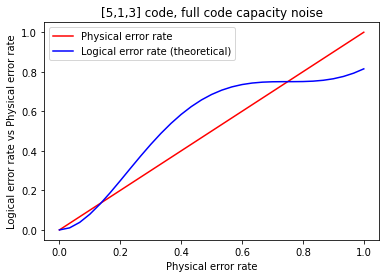

In [12]:
p = np.linspace(0,1,31)

logical_error_rate = error_weight_counts[2]*((p/3)**2)*((1-p)**3) + error_weight_counts[3]*((p/3)**3)*((1-p)**2) + error_weight_counts[4]*((p/3)**4)*((1-p)**1) + error_weight_counts[5]*((p/3)**5)

plt.plot(p, p, 'r')
plt.plot(p, logical_error_rate, 'blue')

plt.xlabel('Physical error rate')
plt.ylabel('Logical error rate vs Physical error rate')

plt.legend(['Physical error rate','Logical error rate (theoretical)'])
plt.title('[5,1,3] code, full code capacity noise')

plt.show()

#### This seems to agree with another simulation of the [5,1,3] carried out independently using qecsim package.